In [5]:
import numpy as np
from scipy.stats import multivariate_normal, norm
from dataclasses import dataclass
from typing import Dict, Optional

@dataclass
class Dataset:
    """Container for train/validation/test data"""
    X_train: np.ndarray
    y_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    true_effects: np.ndarray
    beta: np.ndarray

class SyntheticDataGenerator1:
    """
    Generator für synthetische Datensätze mit nonlinearen mixed normal Daten
    """

    def __init__(self, p: int, beta: np.ndarray, beta0: float = 0,
                 mean: np.ndarray = None, sigma: np.ndarray = None):
        """
        Parameters:
        -----------
        p : int
            Anzahl der Features
        beta : np.ndarray
            Koeffizienten für die nonlineare Funktion
        beta0 : float
            Intercept
        mean : np.ndarray
            Mittelwert für die Normalverteilung
        sigma : np.ndarray
            Kovarianzmatrix
        """
        self.p = p
        self.beta = np.array(beta)
        self.beta0 = beta0
        self.mean = np.zeros(p) if mean is None else mean
        self.sigma = np.eye(p) if sigma is None else sigma

    def sample_mixed_normal(self, n: int) -> np.ndarray:
        """
        Generiert mixed normal verteilte Daten
        """

        mu = np.random.uniform(-2, 2, size=1)
        var = np.random.uniform(0.9, 1.1, size=1)
        sigma = np.sqrt(var)
        X1 = np.random.normal(loc=mu, scale=sigma,size=n)

        for i in range(4):

            mu = np.random.uniform(-2, 2, size=1)
            var = np.random.uniform(0.9, 1.1, size=1)
            sigma = np.sqrt(var)
            X1 = np.vstack((X1,np.random.normal(loc=mu, scale=sigma,size=n)))

        n_half = n // 2

        # Erste Hälfte: mean - 1.5, sigma * 0.5
        data1 = multivariate_normal.rvs(
            mean=self.mean - 2.0,
            cov=self.sigma,
            size=n_half
        )

        # Zweite Hälfte: mean + 1.5, sigma * 0.5
        data2 = multivariate_normal.rvs(
            mean=self.mean + 2.0,
            cov=self.sigma,
            size=n - n_half
        )

        # Kombinieren und mischen
        data = np.vstack([data1, data2])
        np.random.shuffle(data)
        print(data.shape)
        print(X1.shape)
        return X1.T

    def dgp_nonlinear(self, x: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Nonlineare Data Generating Process Funktion
        """
        # Schwellenwert für 75% Quantil der Standardnormalverteilungy
        threshold1 = norm.ppf(0.75)  # ≈ 0.674
        threshold2 = 1.5

        # Nonlineare Transformation
        effects = np.where(np.abs(x) < threshold1, 1, -1)

        # Zusätzliche Bedingung für |x| >= 1.5
        mask = np.abs(x) >= threshold2
        effects = np.where(
            mask,
            np.sign(x) * 0.05 * (x**2 - threshold2**2) - 1,
            effects
        )

        # Offset hinzufügen
        effects = effects + 0.25

        # Mit Beta-Koeffizienten gewichten
        effects = effects * self.beta

        # Linear predictor und Effekte zurückgeben
        lp = np.sum(effects, axis=1) + self.beta0

        return {
            'lp': lp,
            'effects': effects
        }
    def create_dataset(self, n: int, n_test: int,
                        outcome_type: str = 'regression',
                        noise_std: float = 1.0, val_split: float = 0.3, random_state: Optional[int] = None):
        """
        Generiert kompletten Datensatz

        Parameters:
        -----------
        n_train : int
            Anzahl Trainingsdaten
        n_test : int
            Anzahl Testdaten
        outcome_type : str
            'regression' oder 'classification'
        noise_std : float
            Standardabweichung des Rauschens (nur für Regression)
        """

        # Validierungsgröße (30% der Trainingsdaten)
        n_val = int(0.3 * n)
        n_train_actual = n - n_val

        # Daten sampeln
        data = self.sample_mixed_normal(n+n_test)
        train_data = data[n_val+n_test:]#self.sample_mixed_normal(n_train_actual)
        val_data = data[:n_val]#self.sample_mixed_normal(n_val)
        test_data = data[n_val:n_val+n_test]#self.sample_mixed_normal(n_test)

        # Ground truth für alle Datensätze
        train_dgp = self.dgp_nonlinear(train_data)
        val_dgp = self.dgp_nonlinear(val_data)
        test_dgp = self.dgp_nonlinear(test_data)

        # Zielvariablen generieren

        train_y = train_dgp['lp'] + np.random.normal(0, noise_std, n_train_actual)
        val_y = val_dgp['lp'] + np.random.normal(0, noise_std, n_val)
        test_y = test_dgp['lp'] + np.random.normal(0, noise_std, n_test)


        return Dataset(
            X_train=train_data,
            y_train=train_y,
            X_val=val_data,
            y_val=val_y,
            X_test=test_data,
            y_test=test_y,
            true_effects=test_dgp['effects'],
            beta=self.beta
        )

In [6]:
a = np.array([1, 2, 3])

b = np.array([4, 5, 6])

c = np.array([4, 5, 6])

d = np.vstack((a,b))

print(d)
print(np.vstack((d,c)))

[[1 2 3]
 [4 5 6]]
[[1 2 3]
 [4 5 6]
 [4 5 6]]


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple, Optional

class SyntheticDataGenerator2:
    """Generator for synthetic datasets with linear relationships and mixed normal features"""

    def __init__(self, p: int, beta: np.ndarray, beta0: float = 0.0,
                 mean_offset: float = 1.5, sigma_factor: float = 0.5,
                 noise_std: float = 1.0):
        """
        Initialize the generator

        Args:
            p: Number of features
            beta: Coefficient vector (length p)
            beta0: Intercept term
            mean_offset: Offset for the two normal components
            sigma_factor: Scaling factor for covariance matrices
            noise_std: Standard deviation of outcome noise
        """
        self.p = p
        self.beta = np.array(beta)
        self.beta0 = beta0
        self.mean_offset = mean_offset
        self.sigma_factor = sigma_factor
        self.noise_std = noise_std

        # Base parameters for mixed normal
        self.base_mean = np.zeros(p)
        self.base_sigma = np.eye(p)

    def sample_mixed_normal(self, n: int) -> np.ndarray:
        """
        Sample from mixed normal distribution

        Args:
            n: Number of samples

        Returns:
            X: Feature matrix (n x p)
        """
        n_half = n // 2
        n_remainder = n - n_half

        # First component: shifted down
        X1 = np.random.multivariate_normal(
            mean=self.base_mean - self.mean_offset,
            cov=self.sigma_factor * self.base_sigma,
            size=n_half
        )

        # Second component: shifted up
        X2 = np.random.multivariate_normal(
            mean=self.base_mean + self.mean_offset,
            cov=self.sigma_factor * self.base_sigma,
            size=n_remainder
        )

        # Combine and shuffle
        X = np.vstack([X1, X2])
        shuffled_indices = np.random.permutation(n)
        return X[shuffled_indices]

    def generate_linear_outcome(self, X: np.ndarray, outcome_type: str = "regression") -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate linear outcomes

        Args:
            X: Feature matrix
            outcome_type: "regression" or "classification"

        Returns:
            y: Outcome vector
            effects: Individual feature effects (n x p)
        """
        n = X.shape[0]

        # Calculate linear predictor and individual effects
        effects = X * self.beta[np.newaxis, :]  # Broadcasting
        linear_predictor = np.sum(effects, axis=1) + self.beta0

        # Add noise for regression
        y = linear_predictor + np.random.normal(0, self.noise_std, n)

        return y, effects

    def create_dataset(self, n: int, n_test: int, outcome_type: str = "regression",
                      val_split: float = 0.3, random_state: Optional[int] = None) -> Dataset:
        """
        Create complete dataset with train/validation/test splits

        Args:
            n: Training + validation sample size
            n_test: Test sample size
            outcome_type: "regression" or "classification"
            val_split: Fraction of n to use for validation
            random_state: Random seed

        Returns:
            Dataset object with all splits
        """
        if random_state is not None:
            np.random.seed(random_state)

        print("Creating dataset...")

        # Generate training + validation data
        X_trainval = self.sample_mixed_normal(n)
        y_trainval, effects_trainval = self.generate_linear_outcome(X_trainval, outcome_type)

        # Split into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval,
            test_size=val_split,
            random_state=random_state
        )

        # Generate test data
        X_test = self.sample_mixed_normal(n_test)
        y_test, effects_test = self.generate_linear_outcome(X_test, outcome_type)

        print(f"Dataset created! Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

        return Dataset(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            X_test=X_test,
            y_test=y_test,
            true_effects=effects_test,
            beta=self.beta
        )

(1300, 5)
(5, 1300)
Training PyTorch models on synthetic data...

=== MLP Model ===
Epoch  10 | Train Loss: 2.2508 | Val Loss: 2.4332 | Val R²: 0.2884
Epoch  20 | Train Loss: 2.0300 | Val Loss: 2.2840 | Val R²: 0.3263
Epoch  30 | Train Loss: 1.8070 | Val Loss: 2.0166 | Val R²: 0.4006
Epoch  40 | Train Loss: 1.6524 | Val Loss: 1.9487 | Val R²: 0.4179
Epoch  50 | Train Loss: 1.4621 | Val Loss: 1.8785 | Val R²: 0.4363
Epoch  60 | Train Loss: 1.4533 | Val Loss: 1.8076 | Val R²: 0.4565
Epoch  70 | Train Loss: 1.4068 | Val Loss: 1.7774 | Val R²: 0.4667
Epoch  80 | Train Loss: 1.4045 | Val Loss: 1.7113 | Val R²: 0.4839
Early stopping at epoch 85
Training completed in 2.09 seconds
MLP Model Test Results: {'MSE': 1.8413192855057445, 'R²': 0.408019651182961, 'RMSE': 1.3569522045767657}


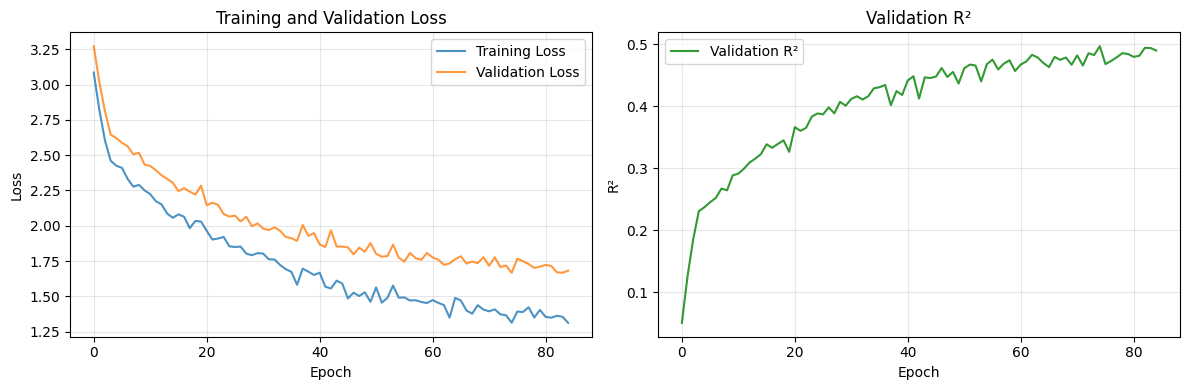

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from typing import Dict, List, Tuple
import time

class MLPRegressor(nn.Module):
    """Multi-layer Perceptron for Regression"""

    def __init__(self, input_dim: int, hidden_dims: List[int] = [64, 32],
                 dropout_rate: float = 0.2):
        super(MLPRegressor, self).__init__()

        layers = []
        prev_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)


class TorchTrainer:
    """Trainer class for PyTorch models"""

    def __init__(self, model: nn.Module,
                 device: str = None):
        self.model = model
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.criterion = nn.MSELoss()

    def prepare_data(self, X: np.ndarray, y: np.ndarray, batch_size: int = 32,
                    shuffle: bool = True) -> DataLoader:
        """Convert numpy arrays to PyTorch DataLoader"""
        X_tensor = torch.FloatTensor(X)

        y_tensor = torch.FloatTensor(y)

        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def train_epoch(self, train_loader: DataLoader, optimizer: optim.Optimizer) -> float:
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(X_batch)
            loss = self.criterion(outputs, y_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        return total_loss / num_batches

    def validate(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Validate the model"""
        self.model.eval()
        total_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                total_loss += loss.item()


                all_preds.extend(outputs.cpu().numpy())

                all_targets.extend(y_batch.cpu().numpy())

        avg_loss = total_loss / len(val_loader)

        metric = r2_score(all_targets, all_preds)

        return avg_loss, metric

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray,
            epochs: int = 100, batch_size: int = 32,
            lr: float = 0.001, weight_decay: float = 1e-5,
            patience: int = 10, verbose: bool = True) -> Dict:
        """Train the model with early stopping"""

        # Prepare data loaders
        train_loader = self.prepare_data(X_train, y_train, batch_size, shuffle=True)
        val_loader = self.prepare_data(X_val, y_val, batch_size, shuffle=False)

        # Setup optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        # Training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_metric': []
        }

        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        start_time = time.time()

        for epoch in range(epochs):
            # Train
            train_loss = self.train_epoch(train_loader, optimizer)

            # Validate
            val_loss, val_metric = self.validate(val_loader)

            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_metric'].append(val_metric)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1

            if verbose and (epoch + 1) % 10 == 0:
                metric_name = "R²"
                print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val {metric_name}: {val_metric:.4f}")

            # Early stopping
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        training_time = time.time() - start_time

        if verbose:
            print(f"Training completed in {training_time:.2f} seconds")

        return history

    def predict(self, X: np.ndarray, batch_size: int = 32) -> np.ndarray:
        """Make predictions"""
        self.model.eval()
        test_loader = self.prepare_data(X, np.zeros(len(X)), batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)

                predictions.extend(outputs.cpu().numpy())

        return np.array(predictions)

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
        """Evaluate model performance"""
        predictions = self.predict(X)

        mse = mean_squared_error(y, predictions)
        r2 = r2_score(y, predictions)
        return {"MSE": mse, "R²": r2, "RMSE": np.sqrt(mse)}

def plot_training_history(history: Dict, task_type: str = "regression"):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss', alpha=0.8)
    ax1.plot(history['val_loss'], label='Validation Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Metric plot
    metric_name = "R²" if task_type == "regression" else "Accuracy"
    ax2.plot(history['val_metric'], label=f'Validation {metric_name}', color='green', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.set_title(f'Validation {metric_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Assuming you have the synthetic dataset from the previous code

    # Generate dataset
    p = 5
    beta = [1.0, -0.5, 0.8, 0.0, -1.2]
    generator = SyntheticDataGenerator1(p=p, beta=beta, beta0=0.2)#SyntheticDataGenerator2(p=p, beta=beta, noise_std=0.5)
    dataset = generator.create_dataset(n=1000, n_test=300, outcome_type="regression", random_state=42)

    print("Training PyTorch models on synthetic data...")

    # 2. MLP Model
    print("\n=== MLP Model ===")
    mlp_model = MLPRegressor(input_dim=p, hidden_dims=[64, 32], dropout_rate=0.1)
    mlp_trainer = TorchTrainer(mlp_model)

    mlp_history = mlp_trainer.fit(
        dataset.X_train, dataset.y_train,
        dataset.X_val, dataset.y_val,
        epochs=100, batch_size=32, lr=0.001
    )

    mlp_results = mlp_trainer.evaluate(dataset.X_test, dataset.y_test)
    print(f"MLP Model Test Results: {mlp_results}")

    # Plot training history
    plot_training_history(mlp_history, task_type="regression")

/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


(300, 5)
(300, 5)
(300, 5)
(300, 5)
Grad Approx


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


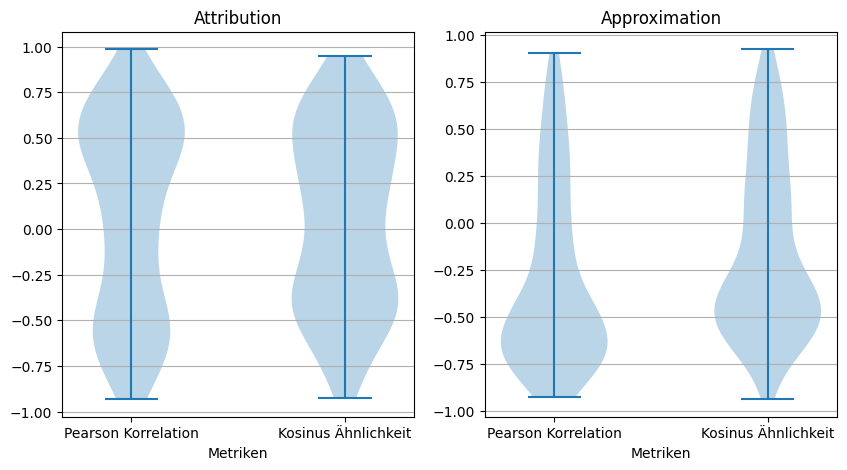

Mean Pearson Correlation:  0.0702135553520785
Mean MSE:  1.290481649890888
Mean Cosine Similarity 0.056438148391281424


In [22]:
from captum.attr import InputXGradient,IntegratedGradients,Saliency
from scipy import stats
from approx_attributes import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

model = mlp_model
X_test = dataset.X_test
X_test_tensor = torch.Tensor(X_test)
aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
Ig = IntegratedGradients(model)
ix = IxG.attribute(X_test_tensor).detach()
igt = Ig.attribute(X_test_tensor).detach()

print(X_test.shape)
attr = Ig.attribute(X_test_tensor).detach()
approx = aa.grad_x_i_approx(X=X_test_tensor,h=0.001).reshape((300,5))
print(X_test.shape)
print(approx.shape)
print(dataset.true_effects.shape)
real = dataset.true_effects






def gen_graph_synth(method="Sal",filename="Synthetische Daten.png",h=0.1):

    pearson_list1 = []
    mse_list1 = []
    cosine_list1 = []
    pearson_list2 = []
    mse_list2 = []
    cosine_list2 = []

    if method == "Sal":
            attr = sal.attribute(X_test_tensor).detach()
            approx = aa.grad_approx(X=X_test_tensor,h=h).reshape((300,5))

    for i in range(real.shape[0]):

        r = real[i]
        a = attr[i]
        ap = approx[i]

        # Pearson-Korrelation
        pearson = np.corrcoef(r, a)[0, 1]
        pearson_list1.append(pearson)
        pearson = np.corrcoef(r, ap)[0, 1]
        pearson_list2.append(pearson)

        # MSE
        mse = mean_squared_error(r, a)
        mse_list1.append(mse)
        mse = mean_squared_error(r, ap)
        mse_list2.append(mse)

        # Cosine Similarity
        cos = cosine_similarity(r.reshape(1, -1), a.reshape(1, -1))[0, 0]
        cosine_list1.append(cos)
        cos = cosine_similarity(r.reshape(1, -1), ap.reshape(1, -1))[0, 0]
        cosine_list2.append(cos)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    # plot box plot
    axs[0].violinplot([pearson_list1, cosine_list1])
    axs[0].set_title('Attribution')

    # adding horizontal grid lines
    axs[0].yaxis.grid(True)
    axs[0].set_xticks([y + 1 for y in range(2)],
                    labels=['Pearson Korrelation', 'Kosinus Ähnlichkeit'])
    axs[0].set_xlabel('Metriken')

    axs[1].violinplot([pearson_list2, cosine_list2])
    axs[1].set_title('Approximation')

    # adding horizontal grid lines
    axs[1].yaxis.grid(True)
    axs[1].set_xticks([y + 1 for y in range(2)],
                    labels=['Pearson Korrelation', 'Kosinus Ähnlichkeit'])
    axs[1].set_xlabel('Metriken')
    #axs.set_ylabel('Metrik')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

    print("Mean Pearson Correlation: ", np.mean(pearson_list1))
    print("Mean MSE: ", np.mean(mse_list1))
    print("Mean Cosine Similarity", np.mean(cosine_list1))
    #print("hö: ", np.mean(np.corrcoef(attr,approx)))
gen_graph_synth(h=2)
#%reset_selective -f [var1, var2, var3]
